## Building An Image Recommendation System For News Articles using Word Embeddings

In [1]:
# loading libraries
import pandas as pd
import numpy as np
import json
import csv
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# python version
import platform
print(f'Python version {platform.python_version()}') # should be 3.7. ours was 3.7.4

# tensorflow
import tensorflow as tf
print(f'Tensorflow version {tf.__version__}') # should be 2.0.0 or greater
import tensorflow_hub as hub

# wordcloud
from wordcloud import WordCloud, STOPWORDS

Python version 3.7.4
Tensorflow version 2.0.0


### Data Loading

In [2]:
# loading the dataset
with open('data/captioning_dataset.json') as json_file:
    data = json.load(json_file)

### Data Cleaning

In [3]:
min_words = 5
ids, headlines, urls, all_images, articles, lens = [], [], [], [], [], []

for i,idx in enumerate(data):
    try:
        headline = data[idx]['headline']['main'].strip()
        num_words = len(headline.split(' '))
        
        # removing article headlines if the number of words in the headline is less than 5
        if num_words < min_words:
            continue

        headlines.append(headline)
        lens.append(num_words)
        all_images.append(data[idx]['images'])
        urls.append(data[idx]['article_url'])
        articles.append(data[idx]['article'])
        ids.append(idx)
    
    # deals with situations where articles are missing a headline
    except:
        continue

# creating a dataframe with our results
article_df = pd.DataFrame({'idx': ids, 'headline': headlines, 'text': articles, 'url': urls, 'num_words': lens})
print(f'Number of Articles: {article_df.shape[0]}')
article_df.head()

Number of Articles: 276596


,idx,headline,text,url,num_words
0,584f1ddf95d0e0392607597e,Rodrigo Duterte Criticizes Times Coverage of P...,His article reported that since the beginning ...,https://www.nytimes.com/2016/12/12/world/asia/...,9
1,54453eab38f0d832c813e7f5,Facebook Seeps Onto Other Web Sites,The moves by Facebook and its rivals set up a ...,https://www.nytimes.com/2010/04/19/technology/...,6
2,5a57160395d0e0110c1a3f23,A Beginner’s Guide to Backing Up Photos,Both Amazon Prime Photos and Dropbox have thei...,https://www.nytimes.com/2018/01/11/smarter-liv...,7
3,55b40f6b38f0d851b1f6dc7c,Black South Carolina Trooper Explains Why He H...,A different sort of photograph had helped to e...,https://www.nytimes.com/2015/07/26/us/black-so...,11
4,51a92bb440e9ec65d203a9e4,The Right Way to Do the Hillary Step,"KETCHUM, Idaho -- SIXTY years ago this week, a...",https://www.nytimes.com/2013/06/01/opinion/the...,8


In [4]:
img_captions, img_article_ids, caption_lens, nums = [], [], [], []

for i, img in enumerate(all_images):
    for k in img.keys():
        caption = img[k].strip()
        num_words = len(caption.split(' '))
        
        # removing article headlines if the number of words in the headline is less than 5
        if num_words < min_words:
            continue
        
        nums.append(k)
        img_captions.append(caption)
        caption_lens.append(num_words)
        img_article_ids.append(ids[i])
        
# creating a dataframe with our results        
image_df = pd.DataFrame({'article_idx': img_article_ids, 'caption': img_captions, 
                         'num_words': caption_lens, 'number': nums})
print(f'Number of Images: {image_df.shape[0]}')
image_df.head()

Number of Images: 431841


,article_idx,caption,num_words,number
0,584f1ddf95d0e0392607597e,A woman grieved as she waited for the body of ...,27,1
1,584f1ddf95d0e0392607597e,The body of a man killed by unknown gunmen lay...,16,0
2,584f1ddf95d0e0392607597e,"The funeral of Jimboy Bolasa, 25, who was foun...",14,3
3,584f1ddf95d0e0392607597e,The body of a man killed by unidentified gunme...,16,2
4,54453eab38f0d832c813e7f5,Mark Zuckerberg is the chief executive of Face...,8,0


### Exploratory Data Analysis

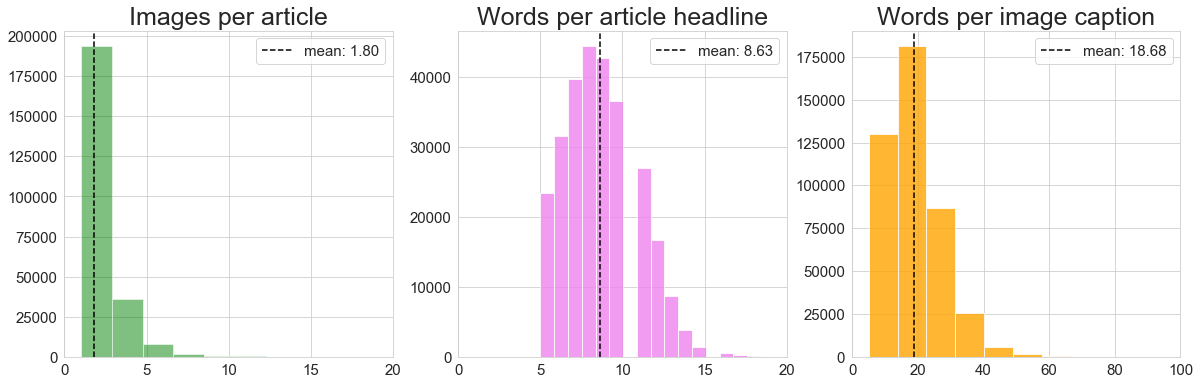

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

# plotting constants
bins = 25
colors = ['green', 'violet', 'orange']
alphas = [0.5, 0.8, 0.8]
fontsize = 25
medfont = 15
lc = 'black'
ls = '--'

# images per article
nums = image_df.groupby('article_idx').count()['caption'].values
ax[0].hist(nums, bins=bins, color=colors[0], alpha=alphas[0])
ax[0].axvline(np.mean(nums), label=f'mean: {np.mean(nums):.2f}', color=lc, linestyle=ls)
ax[0].legend(fontsize=medfont)
ax[0].set_xlim(0,20)
ax[0].tick_params(axis = 'both', which = 'major', labelsize = medfont)
ax[0].set_title(f'Images per article', fontsize=fontsize)

# num words per article headline
headline_words = article_df['num_words'].values
ax[1].hist(headline_words, bins=bins, color=colors[1], alpha=alphas[1])
ax[1].axvline(np.mean(headline_words), label=f'mean: {np.mean(headline_words):.2f}', color=lc, linestyle=ls)
ax[1].legend(fontsize=medfont)
ax[1].set_xlim(0,20)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = medfont)
ax[1].set_title(f'Words per article headline', fontsize=fontsize)

# num words per image caption
caption_words = image_df['num_words'].values
ax[2].hist(caption_words, bins=bins, color=colors[2], alpha=alphas[2])
ax[2].axvline(np.mean(caption_words), label=f'mean: {np.mean(caption_words):.2f}', color=lc, linestyle=ls)
ax[2].legend(fontsize=medfont)
ax[2].set_xlim(0,100)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = medfont)
ax[2].set_title(f'Words per image caption', fontsize=fontsize);

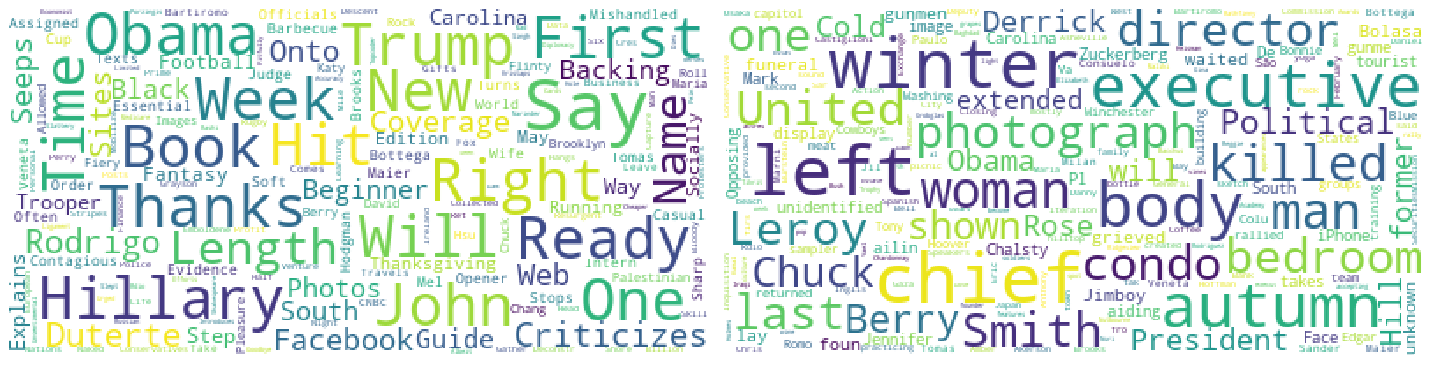

In [6]:
stopwords = set(STOPWORDS)
cloud = WordCloud(background_color='white', stopwords=stopwords, random_state=200, max_font_size=40)

fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].set_axis_off()
wordcloud_article = cloud.generate(str(article_df['headline']))
ax[0].imshow(wordcloud_article)

ax[1].set_axis_off()
wordcloud_image = cloud.generate(str(image_df['caption']))
ax[1].imshow(wordcloud_image)

fig.tight_layout();

### GloVe Embeddings

In [7]:
# loading glove data file
D = 50
glove_data_file = f'data/glove.6B.{D}d.txt'
words = pd.read_csv(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

# creating a dictionary for accessing words quickly
words_dict = {word: embed for word, embed in zip(words.index, words.values.tolist())}
print(f'Loaded {len(words_dict.keys())} words from the GloVe file')

Loaded 399998 words from the GloVe file


In [8]:
def vec(w, D=50):
    """
    Converts a word to an embedding vector
    """
    try:
        return np.array(words_dict[w])
    # if the word is not in our vocabulary, we return zeros
    except:
        return np.zeros(D)

def average_embedding(sentence, D=50):
    """
    Computes the average embedding of a sentence
    """
    total_embeddings = np.zeros(D)
    num_words = len(sentence.split())
    
    # a sanity check
    if num_words == 0:
        return total_embeddings
    
    # getting the embedding for each word
    for word in sentence.split():
        emb = vec(word)
        total_embeddings += emb
        
    # averaging the embeddings
    avg_embeddings = total_embeddings/num_words
    
    # so that we are not dividing by zero
    if np.linalg.norm(avg_embeddings) > 1e-10:
        return avg_embeddings/np.linalg.norm(avg_embeddings)
    else:
        return avg_embeddings

def preprocessing(sentence):
    """
    Preprocessing. Removes punctuation and stop words
    """
    # removing extra whitespace and making the sentence lower case
    sentence = sentence.lower().strip()
    
    # removing punctuation
    bad_chars = '-.?;,!@#$%^&*()+/{}[]\\":\'“’'
    for char in bad_chars:
        sentence = sentence.replace(char, ' ').strip()
    all_words = sentence.split()
    
    # removing stop words
    filtered_sentence = [w for w in all_words if not w in stopwords]
    return ' '.join(filtered_sentence)

In [9]:
# image embeddings
start_time = time.time()

# saving the embeddings for all the image captions to a numpy array
image_embeddings = np.zeros(shape=(len(image_df), D))
for i, text in enumerate(image_df.caption.values):
    if i % 100000 == 0 and i > 0:
        print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')
    text_prep = preprocessing(text)
    emb = average_embedding(text_prep)
    image_embeddings[i] = average_embedding(text_prep)
print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')

100000 out of 431841 done in 15.30s
200000 out of 431841 done in 29.69s
300000 out of 431841 done in 44.46s
400000 out of 431841 done in 59.54s
431840 out of 431841 done in 64.81s


### Universal Sentence Encoding Embeddings

In [10]:
use_encoder = hub.load('data/use_model')
print('Loaded USE Model')

Loaded USE Model


In [11]:
start_time = time.time()

# saving the use embeddings for all the image captions to a numpy array
use_img_embedding = np.zeros((len(image_df),512))
for i, text in enumerate(image_df.caption.values):
    if i % 100000 == 0 and i > 0:
        print(f'{i} out of {len(image_df.caption.values)} done in {time.time() - start_time:.2f}s')
    emb = use_encoder([text])
    use_img_embedding[i] = emb
print(f'{i} out of {len(image_df.caption.values)} done')

# normalize embeddings
use_img_embedding_normalized = use_img_embedding/np.linalg.norm(use_img_embedding,axis=1).reshape(-1,1)

100000 out of 431841 done in 162.92s
200000 out of 431841 done in 326.72s
300000 out of 431841 done in 494.39s
400000 out of 431841 done in 661.34s
431840 out of 431841 done


### Predictions and Results
#### Image Caption Prediction

In [12]:
def predict_glove_images(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # pre-processes the headline
    text_prep = preprocessing(headline)
    
    # finding the average embedding for the headline
    emb = average_embedding(text_prep)
    
    # normalizing the embeddings
    emb = emb.reshape(-1,1)/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(image_embeddings, emb).flatten()
    
    # predict top k images
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

def predict_use_images(headline, k=2):
    """
    Predicts the closest matching image caption given an article headline
    Returns a list of image ids
    """
    # finding the embedding. No pre-processing is needed
    emb = use_encoder([headline])
    
    # normalizing the embeddings
    emb = emb/np.linalg.norm(emb)
    
    # calculating the cosine distance. 
    # since the embeddings are normalized: this is the dot product of the embedding vector and the matrix
    scores_images = np.dot(emb,use_img_embedding.T).flatten()
    
    # predict top k images
    top_k_images = image_df.iloc[np.argsort(-scores_images)[:k]]
    return top_k_images

In [13]:
k = 2
ind = 97043 # np.random.randint(0, len(article_df)) # 97043
article = article_df.iloc[ind]
article_id = article['idx']
headline = article['headline']
url = article['url']

print(f'Article id: {article_id}, headline: {headline}')
print(f'Url: {url}')

Article id: 56c460d038f0d82fc3a19bcd, headline: Reinvention in Walla Walla’s Wine Country
Url: https://www.nytimes.com/2016/02/21/travel/walla-walla-wineries-restaurants.html


GloVe Predictions


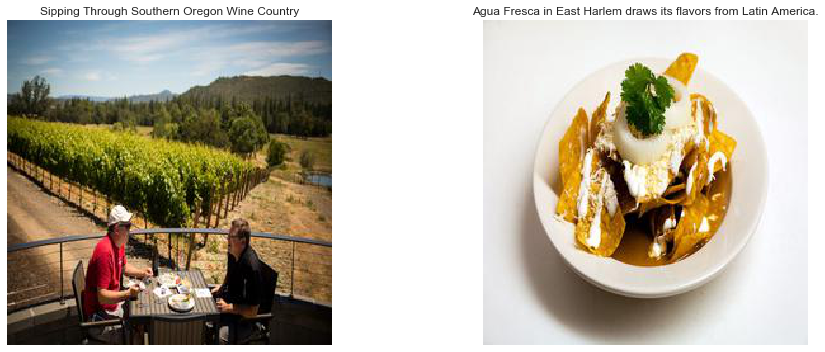

In [14]:
# glove predictions
results_glove = predict_glove_images(headline, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_glove.article_idx.values
captions = results_glove.caption.values
nums = results_glove.number.values

print('GloVe Predictions')
for i in range(k):
    img = plt.imread(f'data/images/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

USE Predictions


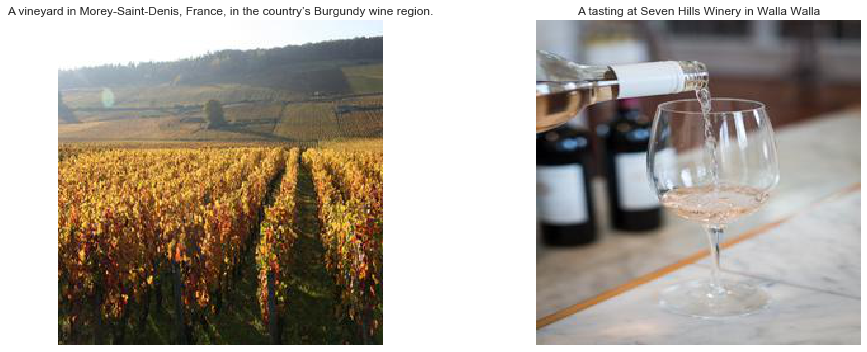

In [15]:
# use predictions
results_use = predict_use_images(headline, 2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
idx = results_use.article_idx.values
captions = results_use.caption.values
nums = results_use.number.values

print('USE Predictions')
for i in range(k):
    img = plt.imread(f'data/images/{idx[i]}_{nums[i]}.jpg')
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(captions[i])
fig.tight_layout()

---